In [1]:
!pip install neurokit2

In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import neurokit2 as nk
from scipy.io import loadmat  # this is the module that loads mat-files

plt.rcParams['figure.figsize'] = [13, 10]
plt.rcParams.update({'font.size': 20})
#%matplotlib inline

In [2]:
def remove_baseline(df):
    #window=0.5*128, stepsize=0.1*128 või window=1*128, stepsize=0.2*128
    df["signal_horizontal_nk"] = nk.signal_detrend(df["signal_horizontal"], method="locreg", window=1.5*1000, stepsize=0.05*1000)
    df["signal_vertical_nk"] = nk.signal_detrend(df["signal_vertical"], method="locreg", window=1.5*1000, stepsize=0.05*1000)
    
    return df

def read_file_into_df(f_name):
    """ 
    Reads data from one .mat file into a DataFrame.
    Expects data files to be in the root/data_raw folder. 
    """
    
    mat = loadmat(f"data_raw/{f_name}")
    df = pd.DataFrame(mat['data'])
    df.columns = ['time_sec', 'time_microsec', 'signal_horizontal', 'signal_vertical', 'class']
    
    df['time_full'] = df['time_sec'] + (df['time_microsec'] / 1_000_000)
    #df['time_full_str'] = df['time_full_str'].astype(str)
    df = df[['time_sec','time_microsec','time_full','signal_horizontal','signal_vertical','class']]

    return df

def read_all_files():
    """
    Reads all data files into DataFrames and puts them into a 2D dictionary.
    To access a file, the first key is the participant (1 - 8), second key is the experiment (0, 1).
    Example: to get the data from the first experiment of participant 5, use dict[5][0]
    """
    
    d = {}
    
    for participant in range(1, 9):
        d[participant] = {}
        
        for experiment in range(0, 2):
            d[participant][experiment] = remove_baseline(read_file_into_df(f"participant{participant}_{experiment}.mat"))
    return d

def all_datasets_read_correctly(d):
    """ Checks if all datasets were read correctly (all datasets contain all classes). """
    
    nr_of_datasets = 0
    
    for p in range(1, 9): # participant
        p_dict = d[p]
    
        for e in range(0, 2): # experiment
            e_dict = p_dict[e]
            labels = e_dict['class'].unique()
            
            for c in range(1, 9): # class label
                if c not in labels:
                    print(f"Class {c} not found in participant {p} experiment {e}!")
                    return
            nr_of_datasets += 1
    print("Looks good! All experiments contain all classes.")
    print(f"Total {nr_of_datasets} datasets from 16 experiments.")
    
def print_dataset_sizes(d):
    for participant, exps in d.items():
        for experiment, data in exps.items():
            print(f"participant:{participant}   experiment:{experiment}   total rows:{len(data.index)}")
            
            for class_label in range(1, 9):
                df_class = data[data['class'] == class_label]
                print(f"\t\t     class:{class_label}   nr of rows:{len(df_class.index)}")
                
            print()
            
def machine_measuring_consistency(d):
    stds = np.array([])
    means = np.array([])

    for participant, exps in d.items():
        for experiment, data in exps.items():
            print(f"participant:{participant}   experiment:{experiment}")

            for class_label in range(1, 9):
                class_df = data[data['class'] == class_label]
                measurements = np.asarray(class_df['time_full'])
                helper = np.insert(measurements, 0, 0)

                last = measurements[-1]
                measurements = np.append(measurements, last)

                timediffs = np.asarray(measurements - helper)[1:-1]
                std = round(np.std(timediffs), 4)
                mean = round(np.mean(timediffs), 4)
                print(f"\tclass:{class_label}   measuring time std:{std} (sec)   mean:{mean} (sec)")
                stds = np.append(stds, std)
                means = np.append(means, mean)
            print()

    print(f"Mean std: {np.mean(stds)}")
    print(f"Mean mean: {np.mean(means)}")
    
def plot_column_with_class_colors(x, y, dataset_dict, participant, experiment, col_name):
    color_dict = {1:'darkorange', 
                  2:'lime', 
                  3:'red', 
                  4:'cyan', 
                  5:'magenta', 
                  6:'darkgoldenrod', 
                  7:'black', 
                  8:'gold'}
    colors = [color_dict[class_] for class_ in dataset_dict[participant][experiment]['class']]
    plt.scatter(x, y, s=0.1, c=colors)
    plt.legend(handles=[mpatches.Patch(color=color, label=class_) for class_, color in color_dict.items()])

In [3]:
# Most of this notebook is commented out to so all of that code wouldn't run when importing the functions to other notebooks



# Reads all datasets into 2D dict.
# First key is participant nr (1 - 8), second is experiment nr (0, 1)
dataset_dict = read_all_files()

# Example use
participant1_experiment0_data = dataset_dict[1][0]

# Do all datasets contain all classes?
#all_datasets_read_correctly(dataset_dict)
print('\n=========================================\n')

# Data sample, columns, and their datatypes
#print(f"Participant 1 experiment 0 data sample:\n\n{participant1_experiment0_data.head(5)}\n")
#print(f"Columns and their data types: \n{participant1_experiment0_data.dtypes}")
print('\n=========================================\n')

# Sizes of datasets.
# Smallest class size belongs to participant 1, experiment 0, class 7; has only 398 rows
#print_dataset_sizes(dataset_dict)
print('On average, 187k rows of data per experiment, 23k per class.')
print('\n=========================================\n')

# How consistent the machine's measuring time was?
print('Average standard deviation of the gap between each measurement in each class of each experiment\n')
#machine_measuring_consistency(dataset_dict)
print('\n=========================================\n')





On average, 187k rows of data per experiment, 23k per class.


Average standard deviation of the gap between each measurement in each class of each experiment





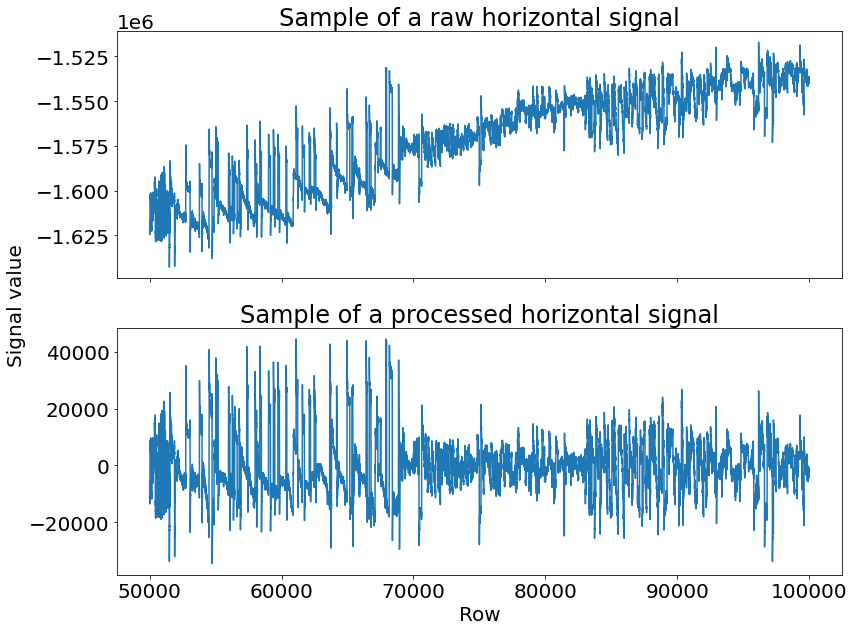

In [52]:
#participant1_experiment0_data['asd'] = nk.signal_detrend(dataset_dict[8][1]["signal_vertical"], method="locreg", window=0.5*128, stepsize=0.1*128)
#plt.plot(dataset_dict[3][0]['signal_horizontal_nk'][50_000:100_000])
#plt.title('Sample of a processed horizontal signal')
#plt.ylabel('Signal value')
#plt.xlabel('Row')
#plt.savefig('proc_h.png')

f, (ax1, ax2) = plt.subplots(2, 1, sharex = True)
f.text(0.008, 0.5, 'Signal value', va='center', rotation='vertical')
ax1.plot(range(50000, 100000), dataset_dict[3][0]['signal_horizontal'][50_000:100_000])
ax1.set_title('Sample of a raw horizontal signal')
ax2.plot(range(50000, 100000), dataset_dict[3][0]['signal_horizontal_nk'][50_000:100_000])
ax2.set_title('Sample of a processed horizontal signal')
plt.xlabel('Row')
#plt.savefig('signal_sample.png')

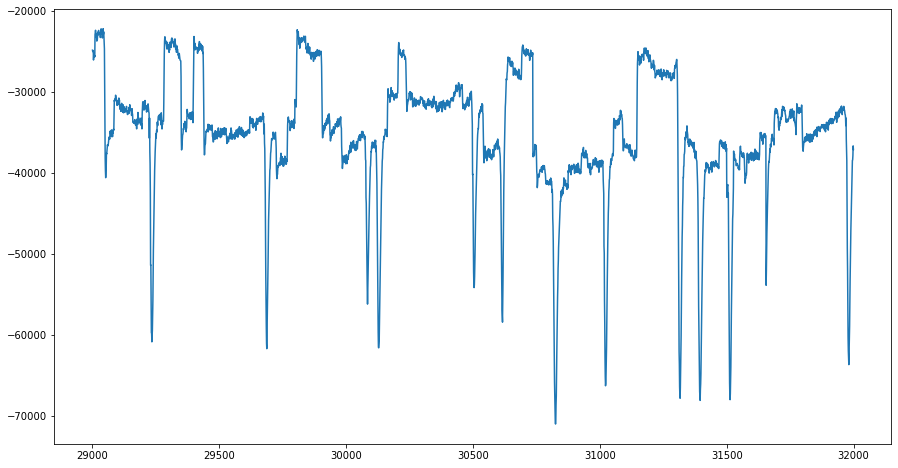

In [28]:
plt.plot(dataset_dict[8][1]['signal_vertical'][29_000:32_000])

In [5]:
# print measurment amounts of given participant and experiment
p, e = 1, 0
#times = dataset_dict[p][e][dataset_dict[p][e]['class'] == 2]['time_sec'].unique()

#for el in times:
    #print(len(dataset_dict[p][e][dataset_dict[p][e]['time_sec'] == el].index))

In [6]:
# For checking how classes are arranged in a dataset
participant, experiment, col_name = 1, 0, 'signal_horizontal_nk'

#plot_column_with_class_colors(x = np.arange(0, len(dataset_dict[participant][experiment][col_name].index), 1),
                              #y = dataset_dict[participant][experiment][col_name],
                              #dataset_dict = dataset_dict,
                              #participant = participant,
                              #experiment = experiment,
                              #col_name = col_name)